## Problem Statement
- Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

- In this problem statement, we'll use bagging and boosting techniques to build a model that can predict what is the chance of a driver leaving based on his attributes

In [429]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,f1_score,confusion_matrix,plot_confusion_matrix,auc,roc_curve
import xgboost as xgb
from category_encoders import *

In [430]:
df = pd.read_csv('ola_driver.csv')

In [431]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [432]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


In [433]:
df.describe(include='all')

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104,19104.000000,19043.000000,19052.000000,19104,19104.000000,19104.000000,19104,1616,19104.000000,19104.000000,1.910400e+04,19104.000000
unique,24,NaN,NaN,NaN,29,NaN,NaN,869,493,NaN,NaN,NaN,NaN
top,01/01/19,NaN,NaN,NaN,C20,NaN,NaN,23/07/15,29/07/20,NaN,NaN,NaN,NaN
freq,1022,NaN,NaN,NaN,1008,NaN,NaN,192,70,NaN,NaN,NaN,NaN
mean,NaN,1415.591133,34.668435,0.418749,NaN,1.021671,65652.025126,NaN,NaN,1.690536,2.252670,5.716621e+05,2.008899
std,NaN,810.705321,6.257912,0.493367,NaN,0.800167,30914.515344,NaN,NaN,0.836984,1.026512,1.128312e+06,1.009832
min,NaN,1.000000,21.000000,0.000000,NaN,0.000000,10747.000000,NaN,NaN,1.000000,1.000000,-6.000000e+06,1.000000
25%,NaN,710.000000,30.000000,0.000000,NaN,0.000000,42383.000000,NaN,NaN,1.000000,1.000000,0.000000e+00,1.000000
50%,NaN,1417.000000,34.000000,0.000000,NaN,1.000000,60087.000000,NaN,NaN,1.000000,2.000000,2.500000e+05,2.000000
75%,NaN,2137.000000,39.000000,1.000000,NaN,2.000000,83969.000000,NaN,NaN,2.000000,3.000000,6.997000e+05,3.000000


## Feature Engineering

In [434]:
def check_rating(group):
    selected = [False] * len(group)
    selected[0] = selected[-1] = True
    new_group = group[selected]
    
    first = new_group['Quarterly Rating'].values[0]
    last = new_group['Quarterly Rating'].values[-1]
    group['Increment Rating'] = 1 if last>first else 0
    return group



In [435]:
df = df.groupby('Driver_ID').apply(check_rating)

In [436]:
df.reset_index(drop=True,inplace=True)

In [437]:
df[df['Increment Rating']==0].tail(20)

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Increment Rating
19053,07/01/19,2782,26.0,0.0,C19,1,29582,16/05/19,NaN,1,1,0,1,0
19054,08/01/19,2782,26.0,0.0,C19,1,29582,16/05/19,16/08/19,1,1,0,1,0
19079,08/01/20,2785,34.0,1.0,C9,0,12105,28/08/20,NaN,1,1,0,1,0
19080,09/01/20,2785,34.0,1.0,C9,0,12105,28/08/20,NaN,1,1,0,1,0
19081,10/01/20,2785,34.0,1.0,C9,0,12105,28/08/20,28/10/20,1,1,0,1,0
19082,01/01/19,2786,44.0,0.0,C19,0,35370,31/07/18,NaN,2,2,221080,2,0
19083,02/01/19,2786,45.0,0.0,C19,0,35370,31/07/18,NaN,2,2,485270,2,0
19084,03/01/19,2786,45.0,0.0,C19,0,35370,31/07/18,NaN,2,2,970380,2,0
19085,04/01/19,2786,45.0,0.0,C19,0,35370,31/07/18,NaN,2,2,432240,2,0
19086,05/01/19,2786,45.0,0.0,C19,0,35370,31/07/18,NaN,2,2,387660,2,0


In [438]:
def create_target(group):
    group['Target'] = 1 if group['LastWorkingDate'].notnull().values.any() else 0
    return group

In [439]:
df = df.groupby('Driver_ID').apply(create_target)

In [440]:
df.reset_index(drop=True,inplace=True)

In [441]:
def check_income(group):
    selected = [False] * len(group)
    selected[0] = selected[-1] = True
    new_group = group[selected]
    
    first = new_group['Income'].values[0]
    last = new_group['Income'].values[-1]
    group['Increment Income'] = 1 if last>first else 0
    return group

df = df.groupby('Driver_ID').apply(check_income)
df.reset_index(drop=True,inplace=True)

In [442]:
df['Total Business Value'] = df.groupby('Driver_ID')['Total Business Value'].sum()

In [443]:
total_business_value = df.groupby(['Driver_ID'])['Total Business Value'].agg('sum')


In [444]:
df = df.drop_duplicates(subset=['Driver_ID'],keep='last')


In [445]:
df = pd.merge(df,total_business_value,on='Driver_ID')

In [446]:
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'],errors='ignore')
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'],errors='ignore')
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'],errors='ignore')

In [447]:
df.isnull().sum()

MMM-YY                       0
Driver_ID                    0
Age                          7
Gender                      10
City                         0
Education_Level              0
Income                       0
Dateofjoining                0
LastWorkingDate            765
Joining Designation          0
Grade                        0
Total Business Value_x    2061
Quarterly Rating             0
Increment Rating             0
Target                       0
Increment Income             0
Total Business Value_y       0
dtype: int64

In [448]:
df[df['Target']==0]

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value_x,Quarterly Rating,Increment Rating,Target,Increment Income,Total Business Value_y
1,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,350000.0,1,0,0,0,350000.0
4,2020-12-01,6,31.0,1.0,C11,1,78728,2020-07-31,NaT,3,3,1017640.0,2,1,0,0,11577480.0
6,2020-12-01,11,28.0,1.0,C19,2,42172,2020-12-07,NaT,1,1,6962550.0,1,0,0,0,6962550.0
9,2020-12-01,14,39.0,1.0,C26,0,19734,2020-10-16,NaT,3,3,NaN,1,0,0,0,5042600.0
17,2020-12-01,25,31.0,0.0,C24,1,102077,2017-10-30,NaT,1,3,6570070.0,4,1,0,0,73731440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,2020-12-01,2775,27.0,0.0,C9,0,85112,2020-10-02,NaT,3,3,NaN,1,0,0,0,0.0
2372,2020-12-01,2778,35.0,0.0,C13,2,50180,2020-11-29,NaT,2,2,NaN,1,0,0,0,0.0
2374,2020-12-01,2781,25.0,0.0,C23,2,46952,2020-02-17,NaT,2,2,NaN,4,1,0,0,0.0
2376,2020-12-01,2784,34.0,0.0,C24,0,82815,2015-10-15,NaT,2,3,NaN,4,1,0,0,0.0


In [449]:
df['Target'].value_counts()

1    1616
0     765
Name: Target, dtype: int64

In [450]:
df.drop(['Total Business Value_x'],axis=1,inplace=True)

In [451]:
df.rename(columns ={'Total Business Value_y':'Cumulative Business value'},inplace=True)

In [452]:
df.isnull().sum()

MMM-YY                         0
Driver_ID                      0
Age                            7
Gender                        10
City                           0
Education_Level                0
Income                         0
Dateofjoining                  0
LastWorkingDate              765
Joining Designation            0
Grade                          0
Quarterly Rating               0
Increment Rating               0
Target                         0
Increment Income               0
Cumulative Business value      0
dtype: int64

## Univariate And Bivariate Analysis

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


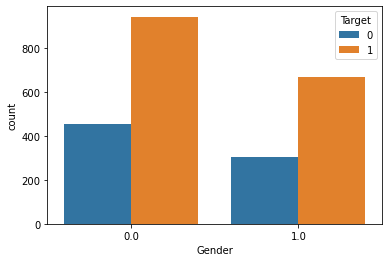

In [453]:
sns.countplot(df['Gender'],hue=df['Target'])
plt.show()

<AxesSubplot:xlabel='Age', ylabel='Density'>

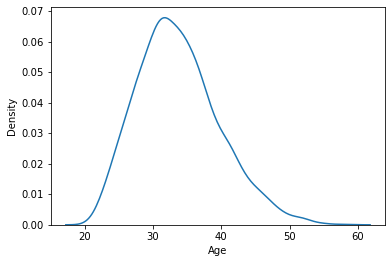

In [454]:
sns.kdeplot(df['Age'])

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


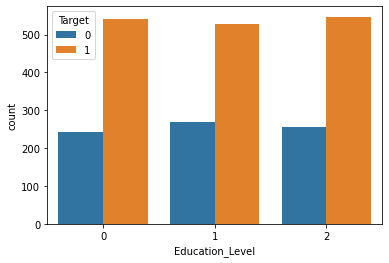

In [455]:
sns.countplot(df['Education_Level'],hue=df['Target'])
plt.show()

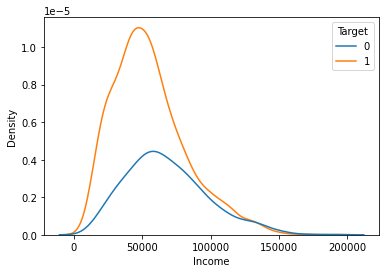

In [456]:
sns.kdeplot(df['Income'],hue=df['Target'])
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


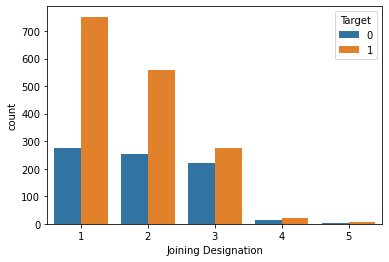

In [457]:
sns.countplot(df['Joining Designation'],hue=df['Target'])
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


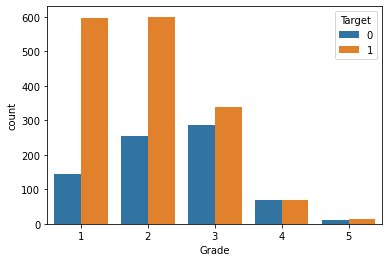

In [458]:
sns.countplot(df['Grade'],hue=df['Target'])
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


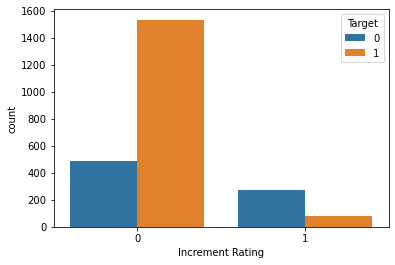

In [459]:
sns.countplot(df['Increment Rating'],hue=df['Target'])
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


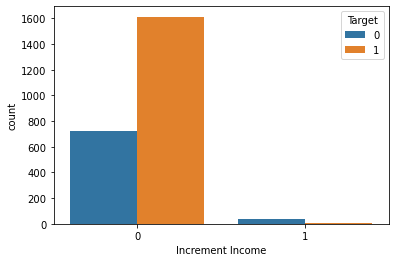

In [460]:


sns.countplot(df['Increment Income'],hue=df['Target'])
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


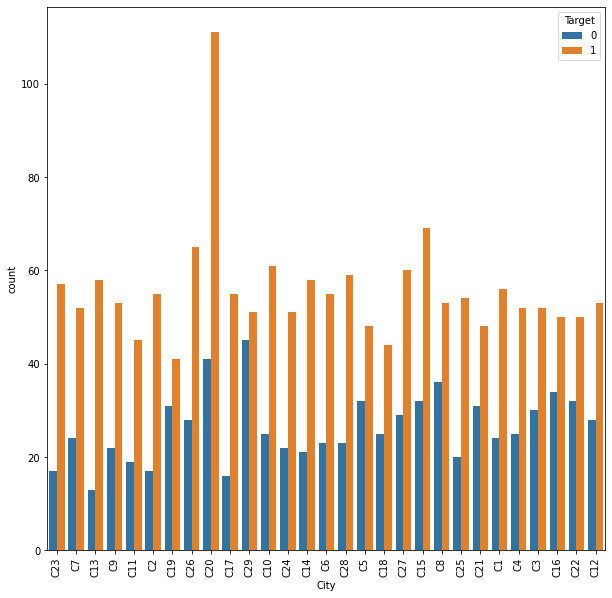

In [461]:
plt.figure(figsize=(10,10))
sns.countplot(df['City'],hue=df['Target'])
plt.xticks(rotation=90)

plt.show()

In [462]:
df

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Quarterly Rating,Increment Rating,Target,Increment Income,Cumulative Business value
0,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,2,0,1,0,1715580.0
1,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,1,0,0,0,350000.0
2,2020-04-01,4,43.0,0.0,C13,2,65603,2019-12-07,2020-04-27,2,2,1,0,1,0,1385360.0
3,2019-03-01,5,29.0,0.0,C9,0,46368,2019-01-09,2019-03-07,1,1,1,0,1,0,2607180.0
4,2020-12-01,6,31.0,1.0,C11,1,78728,2020-07-31,NaT,3,3,2,1,0,0,11577480.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2020-12-01,2784,34.0,0.0,C24,0,82815,2015-10-15,NaT,2,3,4,1,0,0,0.0
2377,2020-10-01,2785,34.0,1.0,C9,0,12105,2020-08-28,2020-10-28,1,1,1,0,1,0,0.0
2378,2019-09-01,2786,45.0,0.0,C19,0,35370,2018-07-31,2019-09-22,2,2,1,0,1,0,0.0
2379,2019-06-01,2787,28.0,1.0,C20,2,69498,2018-07-21,2019-06-20,1,1,1,0,1,0,0.0


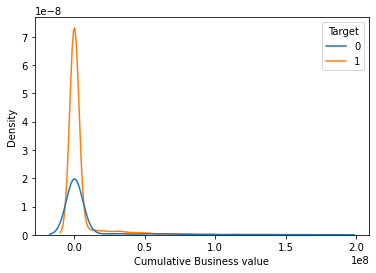

In [463]:
sns.kdeplot(df['Cumulative Business value'],hue=df['Target'])
plt.show()

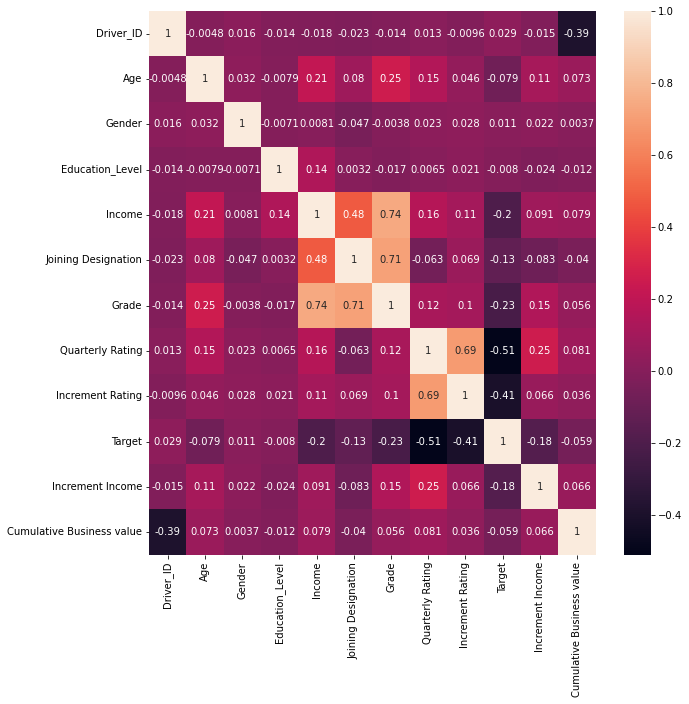

In [464]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)
plt.show()

<div class="alert alert-block alert-info">
<b>Comments:</b>  
    
- City C20 has the highest churn ratio. Most of the drivers are leaving from this city.</br>
- People with no increment in income are more likely to leave in comparison to people to get an increment..</br>
- Drivers with no increment in rating are more likely to leave..</br>
- Riders with Grade 1 or 2 are more likely to leave..</br>
- Riders with joining designation as 1 or 2 are more likely to leave..</br>
- Riders with an average income of around 50,000 are more likely to leave..</br>
</div>

In [465]:
df.drop(['MMM-YY'],axis=1,inplace=True)

In [466]:
df.loc[241]

Driver_ID                                    288
Age                                         41.0
Gender                                       1.0
City                                         C17
Education_Level                                0
Income                                     62901
Dateofjoining                2020-12-18 00:00:00
LastWorkingDate                              NaT
Joining Designation                            2
Grade                                          2
Quarterly Rating                               1
Increment Rating                               0
Target                                         0
Increment Income                               0
Cumulative Business value              3980110.0
Name: 241, dtype: object

In [467]:
df['Target'].value_counts()

1    1616
0     765
Name: Target, dtype: int64

In [468]:
df['tenure'] = (df['LastWorkingDate'] - df['Dateofjoining']).dt.days

In [469]:
bins = [0, 500, 3000]
labels = ['low','medium']
df['tenure'] = pd.cut(x = df['tenure'], bins = bins, labels = labels, include_lowest = True)

In [470]:
df['tenure'] = df['tenure'].astype('string')
df['tenure'] = df['tenure'].fillna('high')


In [471]:
df['tenure'] = df['tenure'].replace({'low':0,'medium':1,'high':2})

In [472]:
df.drop(['Dateofjoining','LastWorkingDate'],axis=1,inplace=True)

In [473]:
df.drop(['Driver_ID'],axis=1,inplace=True)

In [474]:
df['tenure']

0       0
1       2
2       0
3       0
4       2
       ..
2376    2
2377    0
2378    0
2379    0
2380    2
Name: tenure, Length: 2381, dtype: int64

In [475]:
columns = df[['City','Income','Cumulative Business value']]
df.drop(['City','Income','Cumulative Business value'],axis=1,inplace=True)
df_columns = df.columns

In [476]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381 entries, 0 to 2380
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  2374 non-null   float64
 1   Gender               2371 non-null   float64
 2   Education_Level      2381 non-null   int64  
 3   Joining Designation  2381 non-null   int64  
 4   Grade                2381 non-null   int64  
 5   Quarterly Rating     2381 non-null   int64  
 6   Increment Rating     2381 non-null   int64  
 7   Target               2381 non-null   int64  
 8   Increment Income     2381 non-null   int64  
 9   tenure               2381 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 269.2 KB


## Imputing age and gender Column

In [477]:
imputer = KNNImputer(n_neighbors=3)
df = imputer.fit_transform(df)

In [478]:
df = pd.DataFrame(df,columns=df_columns)

In [479]:
df.isnull().sum()

Age                    0
Gender                 0
Education_Level        0
Joining Designation    0
Grade                  0
Quarterly Rating       0
Increment Rating       0
Target                 0
Increment Income       0
tenure                 0
dtype: int64

In [480]:
df = pd.merge(df,columns,left_index=True,right_index=True)

In [481]:
df.drop('tenure',axis=1,inplace=True)

In [482]:
y = df['Target']
X = df.drop('Target',axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [483]:
enc = TargetEncoder(cols=['City'], min_samples_leaf=20, smoothing=10).fit(X_train, y_train)
X_train = enc.transform(X_train)
X_test = enc.transform(X_test)

In [484]:
X_train

,Age,Gender,Education_Level,Joining Designation,Grade,Quarterly Rating,Increment Rating,Increment Income,City,Income,Cumulative Business value
2242,34.0,1.0,0.0,3.0,3.0,1.0,0.0,0.0,0.661365,104058,0.0
1474,42.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.687392,51579,0.0
2132,27.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.800247,75458,0.0
1873,35.0,0.0,1.0,1.0,3.0,3.0,1.0,0.0,0.641139,69756,0.0
462,36.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,0.684972,109296,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1883,39.0,0.0,1.0,1.0,4.0,4.0,1.0,0.0,0.708778,112513,0.0
1355,27.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.704070,49886,0.0
2229,39.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.487972,44154,0.0
2234,28.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.616747,53320,0.0


## Bagging - Random Forest

In [485]:
parameters = {
    'n_estimators':[200,300,500,1000],
    'max_depth':[6,8,10],
    'class_weight':['balanced'],
    #'min_samples_split':[6,8,10],
    'random_state':[42],
    'oob_score':[True],
    
}
rf_model = RandomForestClassifier()
clf_rf = GridSearchCV(rf_model, parameters,scoring='f1',n_jobs=-1)

In [486]:
clf_rf.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'max_depth': [6, 8, 10],
                         'n_estimators': [200, 300, 500, 1000],
                         'oob_score': [True], 'random_state': [42]},
             scoring='f1')

In [487]:
best_rf_model = clf_rf.best_estimator_

In [488]:
print("---------- Confusion Matrix for Train Data ----------")
rf_train_predictions = best_rf_model.predict(X_train) 
print(classification_report(y_train, rf_train_predictions)) 

---------- Confusion Matrix for Train Data ----------
              precision    recall  f1-score   support

         0.0       0.90      0.83      0.86       612
         1.0       0.92      0.96      0.94      1292

    accuracy                           0.91      1904
   macro avg       0.91      0.89      0.90      1904
weighted avg       0.91      0.91      0.91      1904



In [489]:
print("---------- Confusion Matrix for Test Data ----------")
rf_test_predictions = best_rf_model.predict(X_test) 
   
# print classification report 
print(classification_report(y_test, rf_test_predictions)) 

---------- Confusion Matrix for Test Data ----------
              precision    recall  f1-score   support

         0.0       0.69      0.64      0.66       153
         1.0       0.84      0.86      0.85       324

    accuracy                           0.79       477
   macro avg       0.76      0.75      0.76       477
weighted avg       0.79      0.79      0.79       477



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


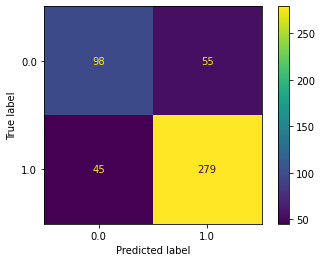

In [490]:
plot_confusion_matrix(best_rf_model,X_test,y_test)

In [491]:
best_rf_model.feature_importances_

array([0.11267364, 0.02502687, 0.03835819, 0.05214781, 0.05432243,
       0.25935888, 0.1103978 , 0.01067393, 0.12766773, 0.16712873,
       0.042244  ])

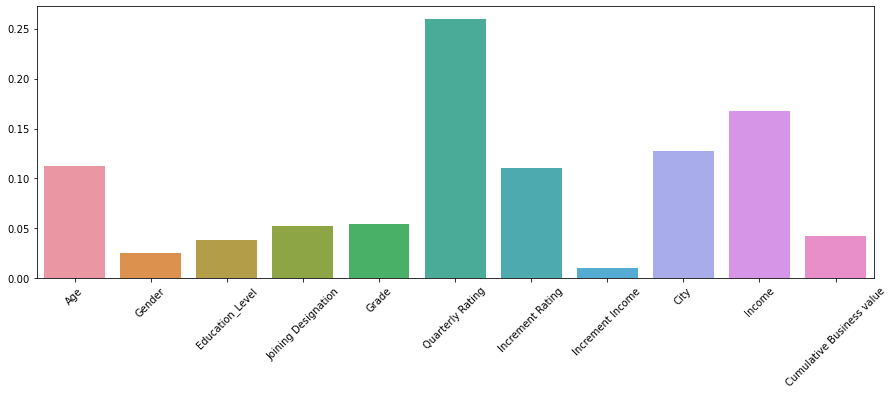

In [492]:
plt.figure(figsize=(15,5))
sns.barplot(x=X_train.columns, y=best_rf_model.feature_importances_)
plt.xticks(rotation=45)
plt.show()

In [493]:
print("f1-score for train data {}".format(f1_score(y_train,rf_train_predictions)))
print("f1-score for test data {}".format(f1_score(y_test,rf_test_predictions)))

f1-score for train data 0.9381404174573055
f1-score for test data 0.8480243161094225


In [494]:
print("Best Params for bagging",clf_rf.best_params_)

Best Params for bagging {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 200, 'oob_score': True, 'random_state': 42}


In [495]:
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = roc_curve(target_test, test_preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


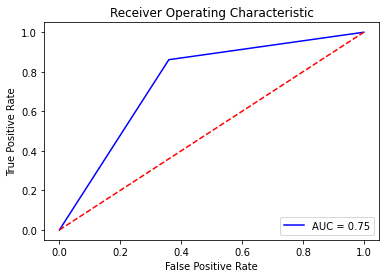

In [496]:
buildROC(y_test,rf_test_predictions)

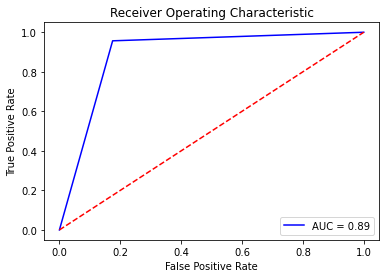

In [497]:
buildROC(y_train,rf_train_predictions)

<div class="alert alert-block alert-success">
<b>Comment On ROC and AUC:</b> Since we are more focused on knowing who'll be leaving the company, we need a high TPR and thus a high threshold value will work for us.
</div>

## Boosting - XGBoost

In [498]:
xgb_model = xgb.XGBClassifier()
parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [4,6,8],
              'subsample': [0.8,0.6,0.4],
              'colsample_bytree': [0.3,0.4,0.5,0.8],
              'scale_pos_weight':[1,10,20,50,100],
              'n_estimators': [1000,200,300], #number of trees, change it to 1000 for better results
              'seed':[42]
            }

clf_xg = GridSearchCV(xgb_model, parameters, n_jobs=-1,scoring='f1') 
clf_xg.fit(X_train,y_train)                 

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5, 0.8],
                         'learning_rate': [0.05], 'max_depth': [4, 6, 8],
                         'n_estimators': [1000, 200, 300],
                         'objective': ['binary:logistic'],
                         'scale_pos_weight': [1, 10, 20, 50, 100], 'seed': [42],
                         'subsample': [0.8, 0.6, 0.4]},
             scoring='f1')

In [499]:
best_xg_model = clf_xg.best_estimator_

In [500]:
clf_xg.best_params_

{'colsample_bytree': 0.3,
 'learning_rate': 0.05,
 'max_depth': 4,
 'n_estimators': 200,
 'objective': 'binary:logistic',
 'scale_pos_weight': 1,
 'seed': 42,
 'subsample': 0.4}

In [501]:
xg_train_predictions = best_xg_model.predict(X_train) 

print(classification_report(y_train, xg_train_predictions)) 

              precision    recall  f1-score   support

         0.0       0.82      0.56      0.67       612
         1.0       0.82      0.94      0.88      1292

    accuracy                           0.82      1904
   macro avg       0.82      0.75      0.77      1904
weighted avg       0.82      0.82      0.81      1904



In [502]:
xg_test_predictions = best_xg_model.predict(X_test) 
   
# print classification report 
print(classification_report(y_test, xg_test_predictions))

              precision    recall  f1-score   support

         0.0       0.81      0.58      0.67       153
         1.0       0.82      0.94      0.88       324

    accuracy                           0.82       477
   macro avg       0.82      0.76      0.77       477
weighted avg       0.82      0.82      0.81       477



In [503]:
print("f1-score for train data {}".format(f1_score(y_train,xg_train_predictions)))
print("f1-score for test data {}".format(f1_score(y_test,xg_test_predictions)))

f1-score for train data 0.8765743073047858
f1-score for test data 0.8757225433526011


In [504]:
y_test.value_counts()

1.0    324
0.0    153
Name: Target, dtype: int64

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


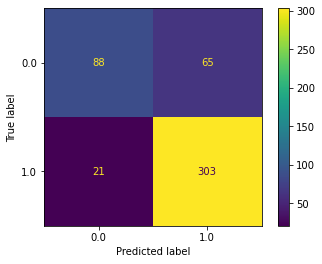

In [505]:
plot_confusion_matrix(best_xg_model,X_test,y_test)

In [506]:
y_train.value_counts()

1.0    1292
0.0     612
Name: Target, dtype: int64

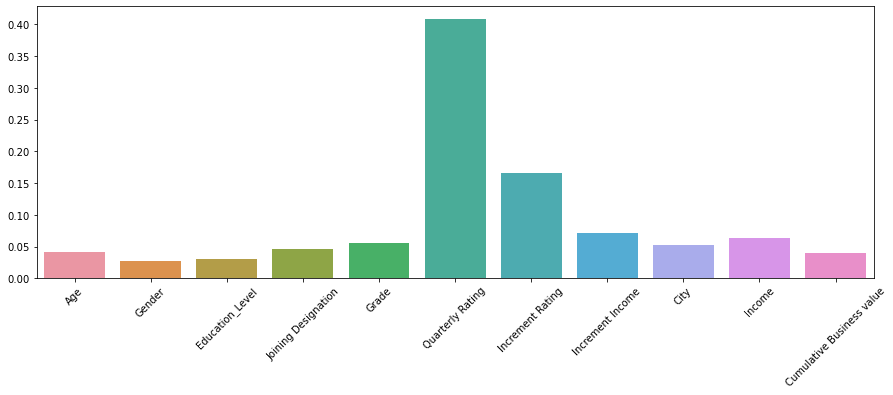

In [507]:
plt.figure(figsize=(15,5))
sns.barplot(x=X_train.columns, y=best_xg_model.feature_importances_)
plt.xticks(rotation=45)
plt.show()

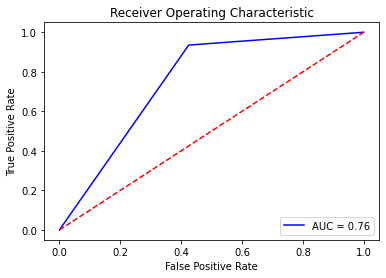

In [508]:
buildROC(y_test,xg_test_predictions)

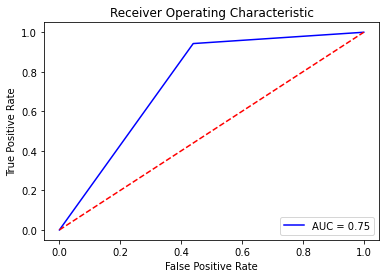

In [509]:
buildROC(y_train,xg_train_predictions)

<div class="alert alert-block alert-success">
<b>Comment On ROC and AUC:</b> Since we are more focused on knowing who'll be leaving the company, we need a high TPR and thus a high threshold value will work for us.
</div>

## Business Insights

- Qaurterly Rating matters a lot because if driver has a drop in rating, it will impact his income and thus will lead to attrition. Companies can work on developing a different metric to rate their performance and also help the drivers having a drop in rating.
- Company can bring in more driver friendly policies like life insurance, medical cover, incentives on increase in quarterly rating etc.
- The company can use the above model to detect if their is an employee having a high chance of leaving and then try to retain that employee.

